<a href="https://colab.research.google.com/github/AJLR888/hmda-ny-2007-loan-default/blob/main/ny_2007_data_preprocesing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HMDA. Mortgage Data Analysis and Modeling Predictions.**

## The Dataset: https://www.consumerfinance.gov/data-research/hmda/

The Home Mortgage Disclosure Act (HMDA) requires many financial institutions to maintain, report, and publicly disclose loan-level information about mortgages. These data help show whether lenders are serving the housing needs of their communities; they give public officials information that helps them make decisions and policies; and they shed light on lending patterns that could be discriminatory. The public data are modified to protect applicant and borrower privacy.

HMDA was originally enacted by Congress in 1975 and is implemented by Regulation C.

## The Goal:
We will use the models Logistic Regression and LightGBM. to assess the outcomes, we will use ROC-AUC and Log Loss. The purpouse will be:


1.   **Find out if the are any intersectional biases** in model's predictions.
2.   **Which features influenced the most on model's outcomes**. We will use SHAP Values.

## Steps:

1.   **Step 1:** Setup of working environment and libraries.

2.   **Step 2:** Overview
  *   A) Understanding features: Know what each column represents and whether it is useful.
  *   B) Understanding the data, shape and structure:

      *   df.shape
      *   df.columns
      *   df.dtypes
      *   df.head()

3.   **Step 3:** Data cleaning
  *   A) Excluding irrelevant records from columns.
      * Quality issues: in "edit_status_name" there are 190,210 records with quality issues. We will ommit them.
      *  Only idividuals: we will focus on individuals hence from 'co_applicant_ethnicity_name' we only keep 'No co-applicant'
  
  *   B) Excluding irrelevant records from:
      *   applicant_ethnicity_name
      *   applicant_race_name_1
      *   applicant_sex_name
      *   action_taken_name
      
  *   C) Addressing missing values:
      *  Filling relevant empty cells with "Unknown"
      *  Deleting irrelevant records from other columns.

  *   D) Mapping action_taken_name into "pproved" & "denied"

  *   E) Feature engineering; Feature creation
      * Creation of the column 'ethnicity_race_sex'

4.   **Step 4:** Exploratory Data Analysis
  *   A) What is the proportion of "denials" to "approvals" for each      record-group from the column "ethnicity_race_sex"?

  *   B) What is the total % of applications for each ethnicity_race_sex group?

  *   C) What are the approval rates?

  *   D) Outliers
  
5.   **Step 5:** Feature engineering
  *   A) Feature creation

  *   B) Feature selection

  *   C) Feature transformation


**Final Considerations:** Please note that at the bottom of some coding blocks we acknowledge external original sources of the code used, if any source is mentioned the creation is original.

# Step 1: Setup of working environment and libraries.




Note:

 *   !git init is for Google Colab environment, we should use "subprocess.run(["git", "init"])" which is more in line with PEP 8 doc. Style.

 *   We only use once "git init", when starting a new project. The purpose of this code is to create things related to the project in a .git directory in the project folder.

 *   subprocess.run(["git", "init"])

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Setting up GitHub
import os
import subprocess
from getpass import getpass #Secure token storage

# Importing working space
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats


In [ ]:
# Username and email:
subprocess.run(["git", "config", "--global", "user.name", "AJLR888"], check=True)
subprocess.run(["git", "config", "--global", "user.email", "roldan.analytics@gmail.com"], check=True)


# Storing GitHub token and repository details
GITHUB_TOKEN = getpass("Enter GitHub Token:")
REPO_OWNER = "AJLR888"
REPO_NAME = "hmda-ny-2007-loan-default"
BRANCH_NAME = "main"

#Setting GitHub remot URL with authentcation
GIT_REMOTE_URL = f"https://{GITHUB_TOKEN}@github.com/{REPO_OWNER}/{REPO_NAME}.git"
os.system(f"git remote set-url origin {GIT_REMOTE_URL}")

Enter GitHub Token:··········


0

In [ ]:
# Loading the data
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/hmda_2007_ny_all-records_labels.csv')

# Checking data size
df = pd.DataFrame(df)


<ipython-input-176-100f7bdf4485>:2: DtypeWarning: Columns (34,36,38,42,44,46,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/hmda_2007_ny_all-records_labels.csv')


# Step 2: General overview



## A)   Understanding of each feature. What does each feature describe?




1.   **as_of_year**: The year the mortgage was reported.
2.   **respondent_id**: The lender.
3.   **agency_name**: The regulatory agency responsible for overseeing the financial institution that reported the mortgage.
4.   **agency_abbr**: Agency abrebiation name.

5.   **agency_code**: The regulator that supervises the regulated lender that report the data.

6.   **loan_type_name**:The type of covered loan or application (if covered). By covered mean, there is a mechanism to protect the lender.

7.   **property_type_name**:

  *   One to four-family (other than manufactured housing)
  *   Manufactured housing
  *   Multifamily


8.   **loan_purpose_name**: What was the loan used for.

9.   **owner_occupancy_name**: Whether the owner intend to live in the property or not.

10.   **loan_amount_000s**

11.   **preapproval_name**: Preapproval only applies to home purchase loans, not refinancing or home improvement loans.

12.   **action_taken_name**: The final outcome of a loan application.

13.   **msamd_name**: MSA stands for Metropolitan Statistical Area, is a region with a high population density at its core and close economic ties throught the area; MD stands for Metropolitan division, is a sub-region within a large MSA (used when the area is particularly populous).


  *   *Considerations*:
    *   If the property is outside of the MSA/MD area it may be blank/empty.
    *   Helps analyze lending patterns, approval rates, and borrower demographics in specific regions.
    *   msamd is broader, city or regional-level in comparison with census_tract_number. msamd is better use for housing trends or market segmentation for instance.

14.   **census_tract_number**: is a small area. Designed to be socially and economically homogeneous. In other words, they are kind of neighbourhoods.

16.   **purchaser_type_name**: Describes who purchased the loan in the secondary market after it was originated by the reporting institution.

17.   **denial_reason_name_1**: Important to consider that if NA the loan was not denied.

18.   **rate_spread:** The exra interest that a borrower pay compared to the "best-qualified" borrowers. Generally speaking it means higher risk although there are nuances to consider. e.g. someone can have a higher rate spread due to a bad credit score which doesn't reflect their ability and will to pay back.

19.   **hoepa_status_name**: hoepa stands for Home Ownership and Equity Protection Act. is a law disgned to protect borrowers from predatory lending.
  *   Considerations:
    *   It can be used to track if high-cost loans are disproportionally targeted at vulnerable groups.

20.   **lien_status_name**: Basically, it indicates whether the mortgage is secured or not.

21.   **edit_status_name**: Are rules to assist filers in checking the accuracy of HMDA data prior to submission. Idicate if there are any accuracy(quality)issues.  
    *   Note: In our dataset we have almost 200,000 records as **"Quality edit failure only"** which is indicative of some potentail data inconsistency.

22.   **minority_population:** % of minority population to total tract population.

23.   **hud_median_family_income:** Median family income for the MSA (metropolitan statistical area) or MD (metropolitan division)
      *   Note: hud(Housing & Urban development).
*   List item

24.   **population**: total population in tract (tract ~ neighbourhood).

25.   **tract_to_msamd_income:** Indicates how wealthy or poor a tract is compared to its surroundings areas. compares the median family income of the census tract to the median family income of the corresponding metropolitan statistical area MSA OR metropolitan division MD. Let's remember that a tract is inside of a MSA/MD.

25.   **number_of_owner_occupied_units:** Total number of housing units in the census tract that are occupied by their owners rather than rented.

26.   **number_of_1_to_4_family_units:** Indicates the number of housing units that are classified as single-family homes. The higher the number the less population density.

--------------------------------------------------------------------------------

Check the following sources for further undertanding:

* Check filing instructions guide for further information: https://ffiec.cfpb.gov/documentation/fig/2024/overview

* Glosary: https://www.ffiec.gov/hmda/glossary.htm#top

* Original source: https://www.consumerfinance.gov/data-research/hmda/historic-data/?geo=nationwide&records=all-records&field_descriptions=labels

* Check "lar_record_codes.pdf" from my GitHub for further Inf.

##  B) Understanding the data

In [ ]:
# Checking content in the columns
pd.set_option('display.max_columns', None)
print(df.head(5))

   as_of_year respondent_id                                  agency_name  \
0        2007    20-2096530    Office of the Comptroller of the Currency   
1        2007    2085300005  Department of Housing and Urban Development   
2        2007    20-2096530    Office of the Comptroller of the Currency   
3        2007    0000003970                 Office of Thrift Supervision   
4        2007    2085300005  Department of Housing and Urban Development   

  agency_abbr  agency_code loan_type_name  loan_type  \
0         OCC            1   Conventional          1   
1         HUD            7   Conventional          1   
2         OCC            1   Conventional          1   
3         OTS            4   Conventional          1   
4         HUD            7   Conventional          1   

                                  property_type_name  property_type  \
0  One-to-four family dwelling (other than manufa...              1   
1  One-to-four family dwelling (other than manufa...            

In [ ]:
# Force to dislplay all rows
pd.set_option('display.max_rows', None)

# Data types
print(df.dtypes)

as_of_year                          int64
respondent_id                      object
agency_name                        object
agency_abbr                        object
agency_code                         int64
loan_type_name                     object
loan_type                           int64
property_type_name                 object
property_type                       int64
loan_purpose_name                  object
loan_purpose                        int64
owner_occupancy_name               object
owner_occupancy                     int64
loan_amount_000s                    int64
preapproval_name                   object
preapproval                         int64
action_taken_name                  object
action_taken                        int64
msamd_name                         object
msamd                             float64
state_name                         object
state_abbr                         object
state_code                          int64
county_name                       

In [ ]:
# Null values
print(df.isnull().sum())

as_of_year                              0
respondent_id                           0
agency_name                             0
agency_abbr                             0
agency_code                             0
loan_type_name                          0
loan_type                               0
property_type_name                      0
property_type                           0
loan_purpose_name                       0
loan_purpose                            0
owner_occupancy_name                    0
owner_occupancy                         0
loan_amount_000s                        0
preapproval_name                        0
preapproval                             0
action_taken_name                       0
action_taken                            0
msamd_name                          92920
msamd                               92920
state_name                              0
state_abbr                              0
state_code                              0
county_name                       

In [ ]:
# Unique values for categorical variables
categorical_columns = df.select_dtypes(include=['object']).columns.drop("respondent_id")
for col in categorical_columns:
  print(f"Value counts for: {col}")
  print(df[col].value_counts(), "\n")
  print("\n" + "=+"*50 + "\n")

Value counts for: agency_name
agency_name
Office of the Comptroller of the Currency      363756
Department of Housing and Urban Development    214451
Office of Thrift Supervision                   199948
Federal Reserve System                         173886
National Credit Union Administration            34779
Federal Deposit Insurance Corporation           22631
Name: count, dtype: int64 


=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+

Value counts for: agency_abbr
agency_abbr
OCC     363756
HUD     214451
OTS     199948
FRS     173886
NCUA     34779
FDIC     22631
Name: count, dtype: int64 


=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+

Value counts for: loan_type_name
loan_type_name
Conventional          966120
FHA-insured            39128
VA-guaranteed           3573
FSA/RHS-guaranteed       630
Name: count, dtype: int64 


=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=

# Step 3: Data cleaning

## A) Excluding irrelevant records from columns

In [ ]:
# Records/columns
df.shape

(1009451, 78)

In [ ]:
# Quality issues: There are 190210 records with quality issues. We will ommit them.
df = df[~df["edit_status_name"].isin(["Quality edit failure only"])]

# Our focus is on individuals hence we will focus on data with "No co-applicant"
df = df[df['co_applicant_ethnicity_name'] == 'No co-applicant']

In [ ]:
# Records/shape
df.shape

(472701, 78)

## B) Excluding irrelevant records from the following columns:

*   applicant_ethnicity_name
*   applicant_race_name_1
*   applicant_sex_name
*   action_taken_name

In [ ]:
df = df[
    ~df["action_taken_name"].isin([
        "File closed for incompleteness",
        "Preapproval request denied by financial institution",
        "Preapproval request approved but not accepted",
        "Application withdrawn by applicant"
    ]) &
    ~df["applicant_ethnicity_name"].isin([
        "Information not provided by applicant in mail, Internet, or telephone application",
        "Not applicable"
    ]) &
    ~df["applicant_race_name_1"].isin([
        "Information not provided by applicant in mail, Internet, or telephone application",
        "Not applicable"
    ]) &
    ~df["applicant_sex_name"].isin([
        "Information not provided by applicant in mail, Internet, or telephone application",
        "Not applicable"
    ])
]


In [ ]:
print(df.shape)

(323044, 78)


## C) Addressing missing values

In [ ]:
print(df.isnull().sum())

as_of_year                             0
respondent_id                          0
agency_name                            0
agency_abbr                            0
agency_code                            0
loan_type_name                         0
loan_type                              0
property_type_name                     0
property_type                          0
loan_purpose_name                      0
loan_purpose                           0
owner_occupancy_name                   0
owner_occupancy                        0
loan_amount_000s                       0
preapproval_name                       0
preapproval                            0
action_taken_name                      0
action_taken                           0
msamd_name                         34069
msamd                              34069
state_name                             0
state_abbr                             0
state_code                             0
county_name                          357
county_code     

### Filling and dropping

In [ ]:
df = df.assign(
    msamd_name=df['msamd_name'].fillna("Unknown"),
    denial_reason_name_1=df['denial_reason_name_1'].fillna("Unknown"),
    rate_spread=df['rate_spread'].fillna(0)
)

df = df.dropna(subset=['county_name',
                       'census_tract_number',
                       'applicant_income_000s',
                       'minority_population',
                       'hud_median_family_income',
                       'tract_to_msamd_income',
                       'number_of_owner_occupied_units',
                       'number_of_1_to_4_family_units'
                       ]
               )


In [ ]:
print(df.isnull().sum())

as_of_year                             0
respondent_id                          0
agency_name                            0
agency_abbr                            0
agency_code                            0
loan_type_name                         0
loan_type                              0
property_type_name                     0
property_type                          0
loan_purpose_name                      0
loan_purpose                           0
owner_occupancy_name                   0
owner_occupancy                        0
loan_amount_000s                       0
preapproval_name                       0
preapproval                            0
action_taken_name                      0
action_taken                           0
msamd_name                             0
msamd                              33468
state_name                             0
state_abbr                             0
state_code                             0
county_name                            0
county_code     

## D) Mapping action_taken_name into "approved" & "denied"

In [ ]:
print(df["action_taken_name"].value_counts())

action_taken_name
Loan originated                                148863
Application denied by financial institution    108294
Application approved but not accepted           31152
Loan purchased by the institution               30532
Name: count, dtype: int64


In [ ]:
atn_map = {
    "Loan originated" : 'approved',
    "Application approved but not accepted" : 'approved',
    "Loan purchased by the institution" : 'approved',
    "Application denied by financial institution" : 'denied'
    }


df["action_taken_name"] = df["action_taken_name"].map(atn_map)

print(df["action_taken_name"].value_counts())

action_taken_name
approved    210547
denied      108294
Name: count, dtype: int64


In [ ]:
print(df.columns)

Index(['as_of_year', 'respondent_id', 'agency_name', 'agency_abbr',
       'agency_code', 'loan_type_name', 'loan_type', 'property_type_name',
       'property_type', 'loan_purpose_name', 'loan_purpose',
       'owner_occupancy_name', 'owner_occupancy', 'loan_amount_000s',
       'preapproval_name', 'preapproval', 'action_taken_name', 'action_taken',
       'msamd_name', 'msamd', 'state_name', 'state_abbr', 'state_code',
       'county_name', 'county_code', 'census_tract_number',
       'applicant_ethnicity_name', 'applicant_ethnicity',
       'co_applicant_ethnicity_name', 'co_applicant_ethnicity',
       'applicant_race_name_1', 'applicant_race_1', 'applicant_race_name_2',
       'applicant_race_2', 'applicant_race_name_3', 'applicant_race_3',
       'applicant_race_name_4', 'applicant_race_4', 'applicant_race_name_5',
       'applicant_race_5', 'co_applicant_race_name_1', 'co_applicant_race_1',
       'co_applicant_race_name_2', 'co_applicant_race_2',
       'co_applicant_race_name_

## E) Feature engineering; Feature creation

In [ ]:
# Creation of ethnicity_race_sex column:
df['ethnicity_race_sex'] = df['applicant_ethnicity_name'].str.lower() + "_" + df['applicant_race_name_1'].str.lower() + "_" + df['applicant_sex_name'].str.lower()

# Checking column created
print(df[['ethnicity_race_sex']].value_counts())

ethnicity_race_sex                                                     
not hispanic or latino_white_male                                          126540
not hispanic or latino_white_female                                         84557
not hispanic or latino_black or african american_female                     27181
not hispanic or latino_black or african american_male                       22053
hispanic or latino_white_male                                               17879
not hispanic or latino_asian_male                                           13608
hispanic or latino_white_female                                             11132
not hispanic or latino_asian_female                                          8975
not hispanic or latino_american indian or alaska native_male                 1116
hispanic or latino_black or african american_male                             937
not hispanic or latino_native hawaiian or other pacific islander_male         922
hispanic or latino_black o

### **Mapping** "ethnicity_race_sex" for better readability:

In [ ]:
# Mapping "ethnicity_race_sex" for better readitability:
ers_map = {
    "not hispanic or latino_white_male": "NH_White_M",
    "not hispanic or latino_white_female": "NH_White_F",
    "not hispanic or latino_black or african american_female": "NH_Black_F",
    "not hispanic or latino_black or african american_male": "NH_Black_M",
    "hispanic or latino_white_male": "H_White_M",
    "not hispanic or latino_asian_male": "NH_Asian_M",
    "hispanic or latino_white_female": "H_White_F",
    "not hispanic or latino_asian_female": "NH_Asian_F",
    "not hispanic or latino_american indian or alaska native_male": "NH_Indigenous_M",
    "hispanic or latino_black or african american_male": "H_Black_M",
    "not hispanic or latino_native hawaiian or other pacific islander_male": "NH_PacificIslander_M",
    "hispanic or latino_black or african american_female": "H_Black_F",
    "not hispanic or latino_native hawaiian or other pacific islander_female": "NH_PacificIslander_F",
    "not hispanic or latino_american indian or alaska native_female": "NH_Indigenous_F",
    "hispanic or latino_native hawaiian or other pacific islander_male": "H_PacificIslander_M",
    "hispanic or latino_american indian or alaska native_male": "H_Indigenous_M",
    "hispanic or latino_native hawaiian or other pacific islander_female": "H_PacificIslander_F",
    "hispanic or latino_american indian or alaska native_female": "H_Indigenous_F",
    "hispanic or latino_asian_male": "H_Asian_M",
    "hispanic or latino_asian_female": "H_Asian_F"
}

df["ethnicity_race_sex"] = df["ethnicity_race_sex"].map(ers_map)

print(df.shape, df["ethnicity_race_sex"].value_counts())

(318841, 79) ethnicity_race_sex
NH_White_M              126540
NH_White_F               84557
NH_Black_F               27181
NH_Black_M               22053
H_White_M                17879
NH_Asian_M               13608
H_White_F                11132
NH_Asian_F                8975
NH_Indigenous_M           1116
H_Black_M                  937
NH_PacificIslander_M       922
H_Black_F                  873
NH_PacificIslander_F       741
NH_Indigenous_F            725
H_PacificIslander_M        436
H_Indigenous_M             385
H_PacificIslander_F        242
H_Indigenous_F             241
H_Asian_M                  175
H_Asian_F                  123
Name: count, dtype: int64


# Step 4: Exploratory Data Analysis

In [ ]:
# horizontal barplot
def value_counts_bar(col, title):
    vc = col.value_counts()
    plt.figure(figsize=(6, len(vc.keys())/2))
    plt.barh(vc.keys(), vc.values)
    plt.title(title, fontsize=15)
    plt.xticks(rotation='vertical', fontsize=10)
    plt.show()

# https://q-shick.github.io/portfolio/proj_hmda.html by By Kyoosik Kim

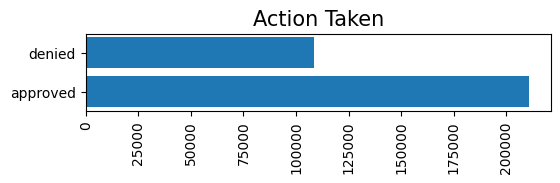

In [ ]:
value_counts_bar(df.action_taken_name, "Action Taken")

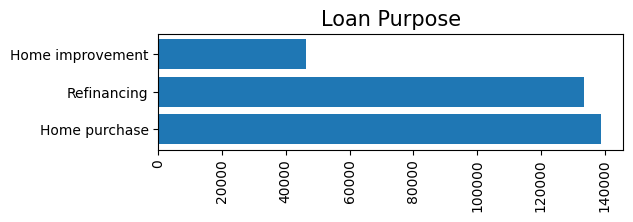

In [ ]:
value_counts_bar(df.loan_purpose_name, "Loan Purpose")

### What is the proportion of "denials" to "approvals" for each record-group from the column "ethnicity_race_sex"?

<Figure size 2000x1000 with 0 Axes>

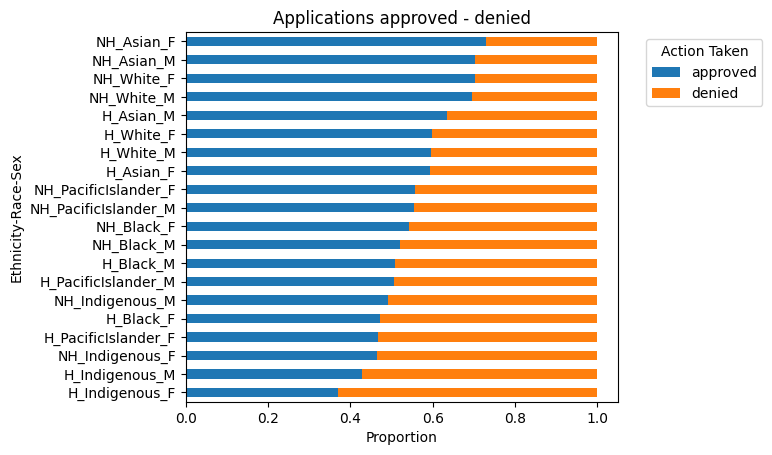

In [ ]:
# Calculating and plotting the distribution of action_taken for each ethnicity_race_sex group
action_distribution = df.groupby(['ethnicity_race_sex', 'action_taken_name']).size().unstack(fill_value=0)
action_distribution_pct = action_distribution.div(action_distribution.sum(axis=1), axis=0)

# Sort the data by 'approved' column
sorted_index = action_distribution_pct['approved'].sort_values(ascending=True).index
action_distribution_pct_sorted = action_distribution_pct.loc[sorted_index]

# Display
plt.figure(figsize=(20, 10))
action_distribution_pct_sorted.plot(kind='barh', stacked=True)

plt.title('Applications approved - denied')
plt.xlabel('Proportion')
plt.ylabel('Ethnicity-Race-Sex')

plt.legend(title='Action Taken', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(right=0.8)

plt.show()

#https://stackoverflow.com/questions/25068384/bbox-to-anchor-and-loc-in-matplotlib
#https://www.geeksforgeeks.org/python-pandas-dataframe-div/

### What is the total % of applications for each ethnicity_race_sex group?

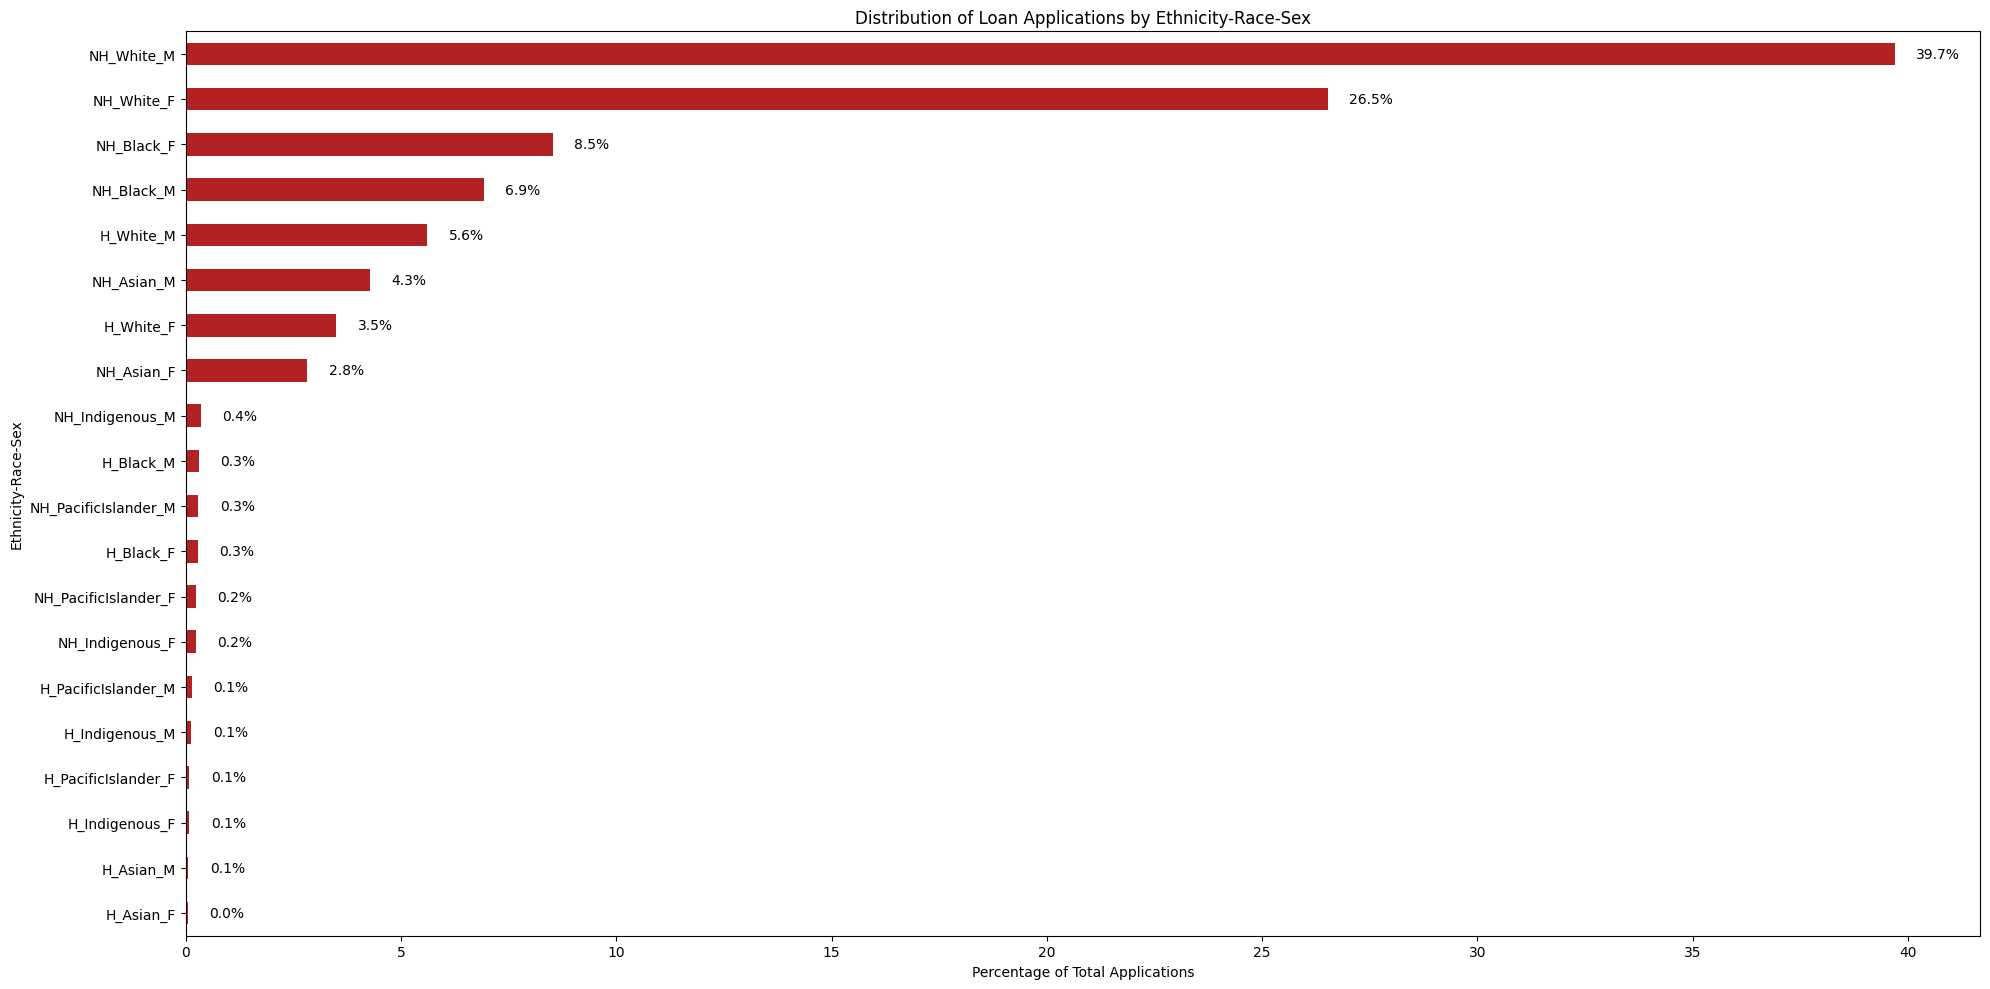

In [ ]:
# Total number of applications (approved + denied) for each ethnicity_race_sex group
total_applications = df.groupby('ethnicity_race_sex')['action_taken_name'].count()

# % distribution of total applications
total_applications_pct = (total_applications / total_applications.sum()) * 100

# Sorting data
total_applications_pct_sorted = total_applications_pct.sort_values(ascending=True)

# Plotting results
plt.figure(figsize=(20, 10))
ax = total_applications_pct_sorted.plot(kind='barh', color='firebrick')

# Labels
plt.title('Distribution of Loan Applications by Ethnicity-Race-Sex')
plt.xlabel('Percentage of Total Applications')
plt.ylabel('Ethnicity-Race-Sex')

# % on bars
for i, v in enumerate(total_applications_pct_sorted):
    ax.text(v + 0.5, i, f'{v:.1f}%', va='center')


plt.tight_layout()
plt.show()

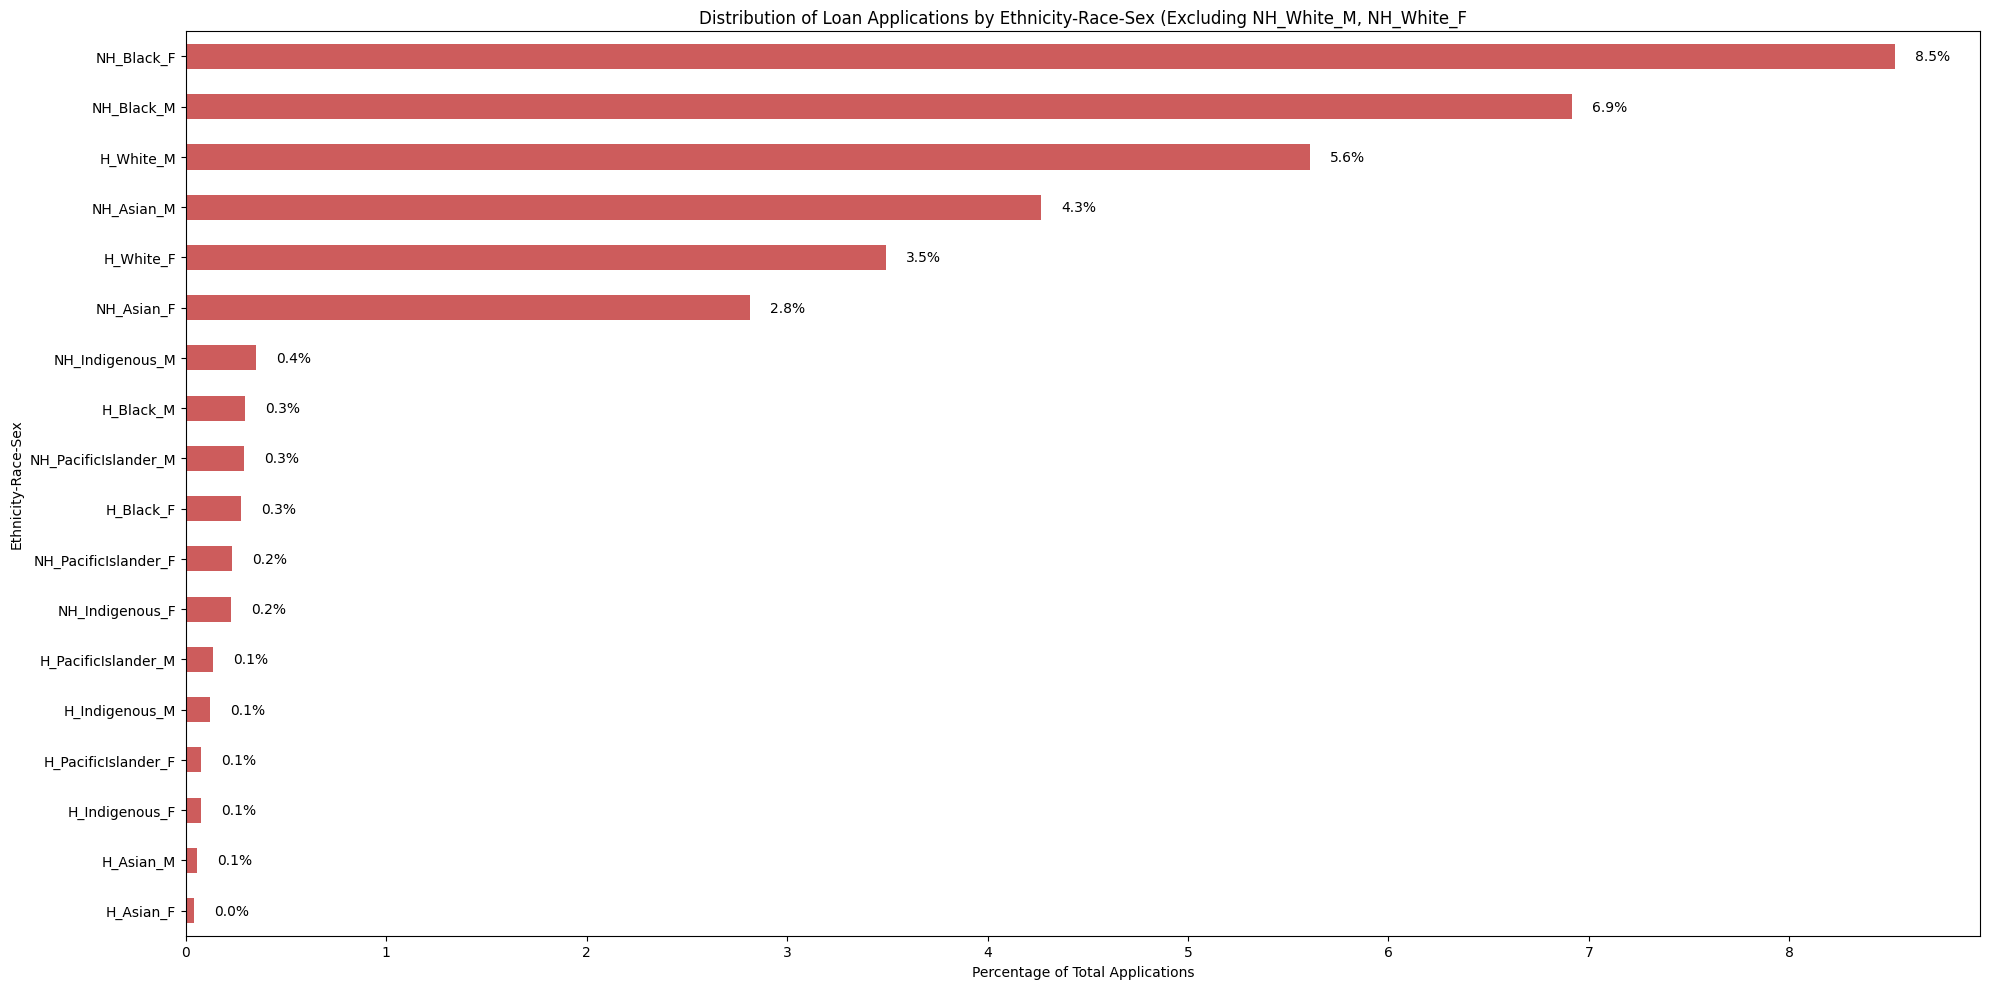

In [ ]:
# Filtering out "not hispanic or latino_white_female" and "not hispanic or latino_white_male"
total_applications = df.groupby('ethnicity_race_sex')['action_taken_name'].count()

# Total number of applications (approved + denied) for each ethnicity_race_sex group
total_applications_pct = (total_applications / total_applications.sum()) * 100

# Filtering out "not hispanic or latino_white_female" and "not hispanic or latino_white_male" from visualization
visualization_pct = total_applications_pct.drop(['NH_White_M', 'NH_White_F'])

# Sortting data
visualization_pct_sorted = visualization_pct.sort_values(ascending=True)

# Plotting
plt.figure(figsize=(20, 10))
ax = visualization_pct_sorted.plot(kind='barh', color='indianred')

# Labels
plt.title('Distribution of Loan Applications by Ethnicity-Race-Sex (Excluding NH_White_M, NH_White_F')
plt.xlabel('Percentage of Total Applications')
plt.ylabel('Ethnicity-Race-Sex')

# % for each bar
for i, v in enumerate(visualization_pct_sorted):
    ax.text(v + 0.1, i, f'{v:.1f}%', va='center')

plt.tight_layout()
plt.show()

### What are the approval rates?

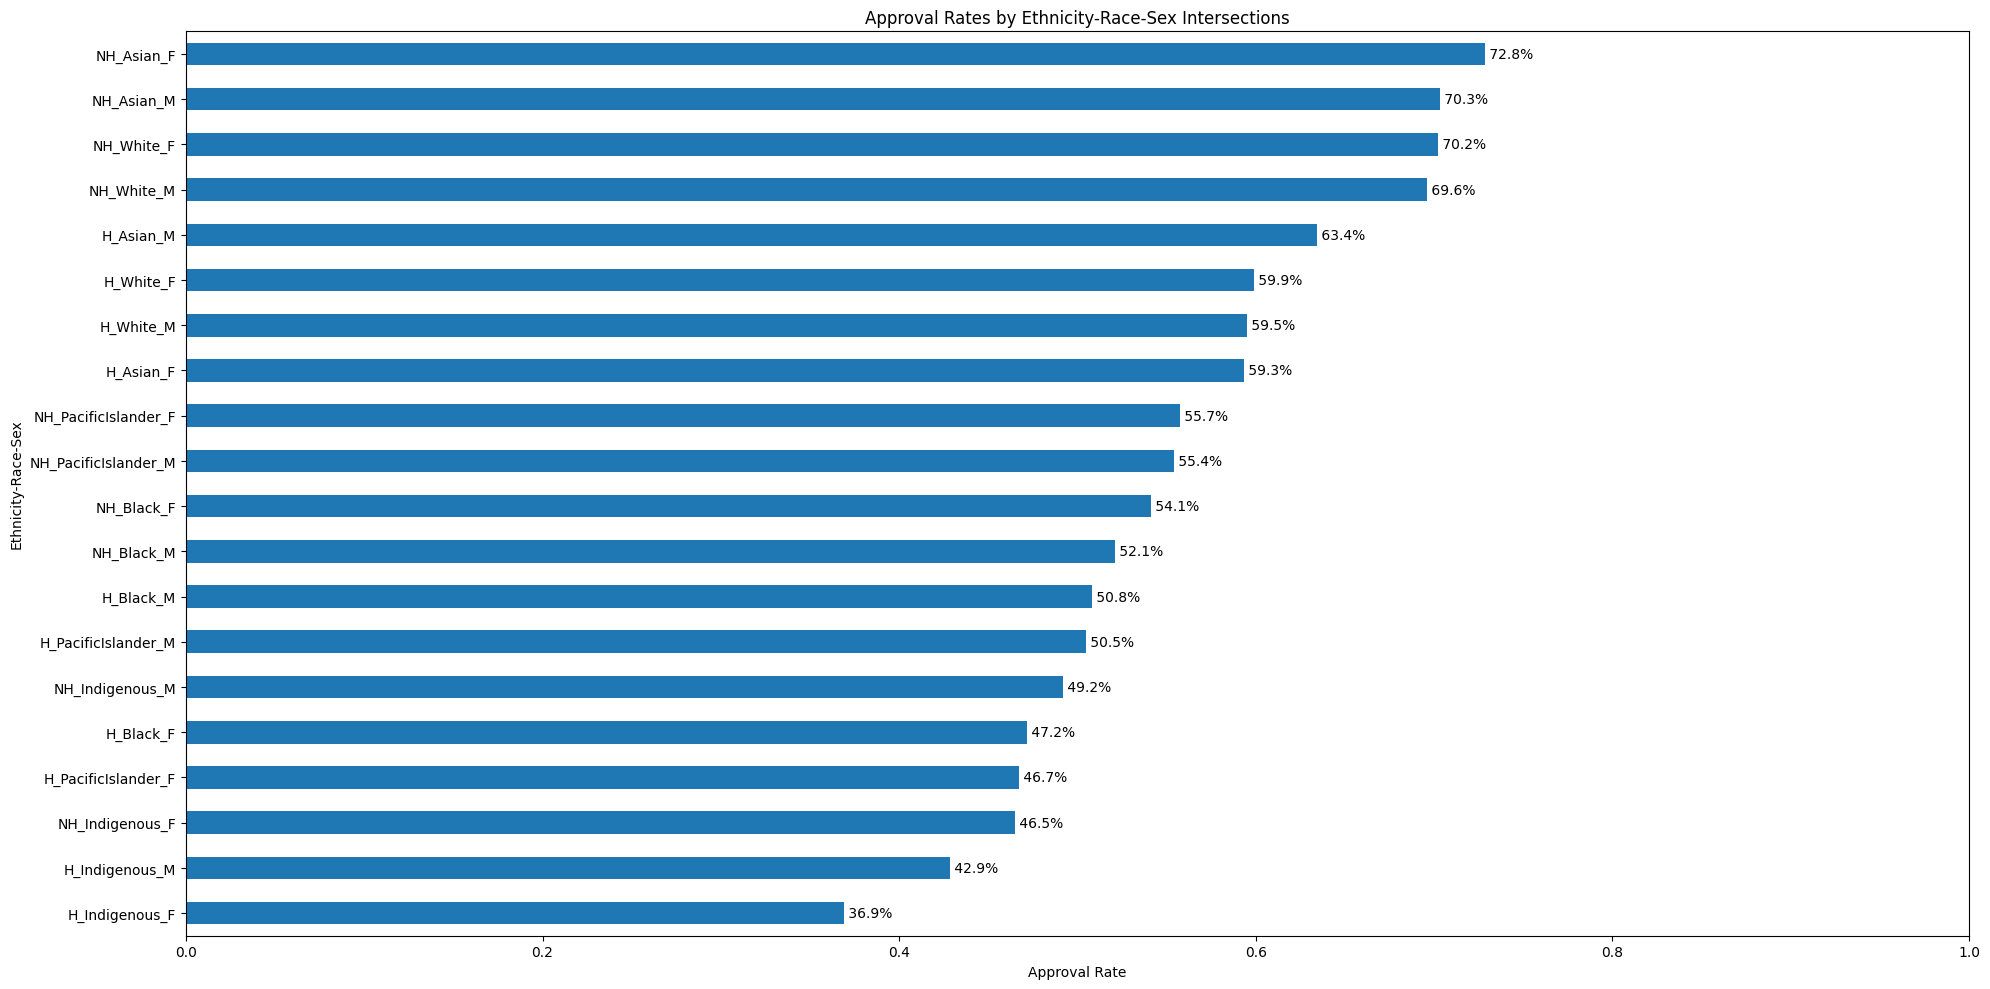

In [ ]:
df['approved'] = (df['action_taken_name'] == 'approved').astype(int)
approval_rates = df.groupby('ethnicity_race_sex')['approved'].mean().sort_values(ascending=True)


plt.figure(figsize=(20, 10))
ax = approval_rates.plot(kind='barh')

plt.title('Approval Rates by Ethnicity-Race-Sex Intersections')
plt.xlabel('Approval Rate')
plt.ylabel('Ethnicity-Race-Sex')
plt.xlim(0, 1)  # Set x-axis limits from 0 to 1 for percentage

# Adding percentage labels
for i, v in enumerate(approval_rates):
    ax.text(v, i, f' {v:.1%}', va='center')

plt.tight_layout()
plt.show()

#https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html
#https://github.com/DJ4seasons/Python_Basic4beginners

### Outliers

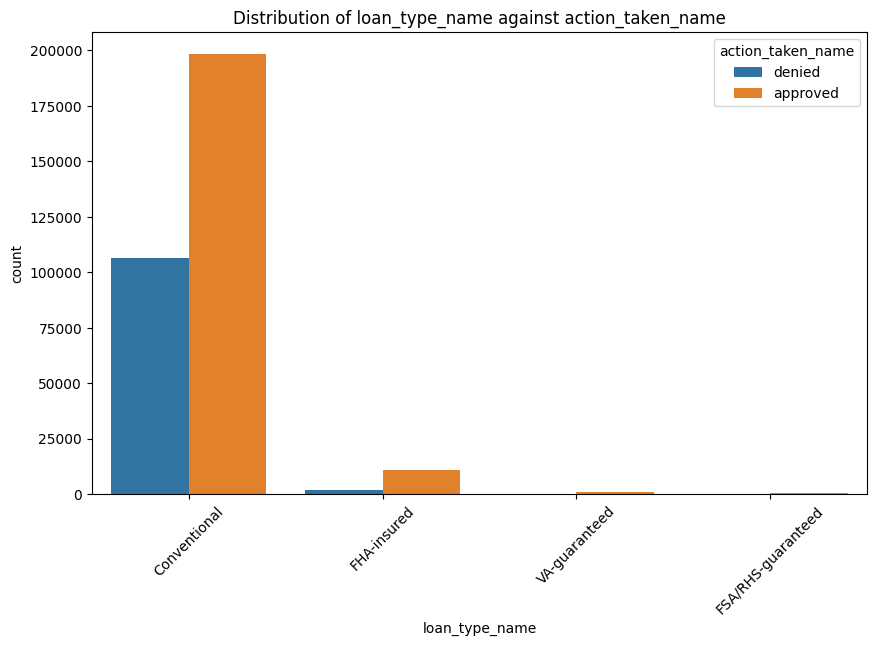

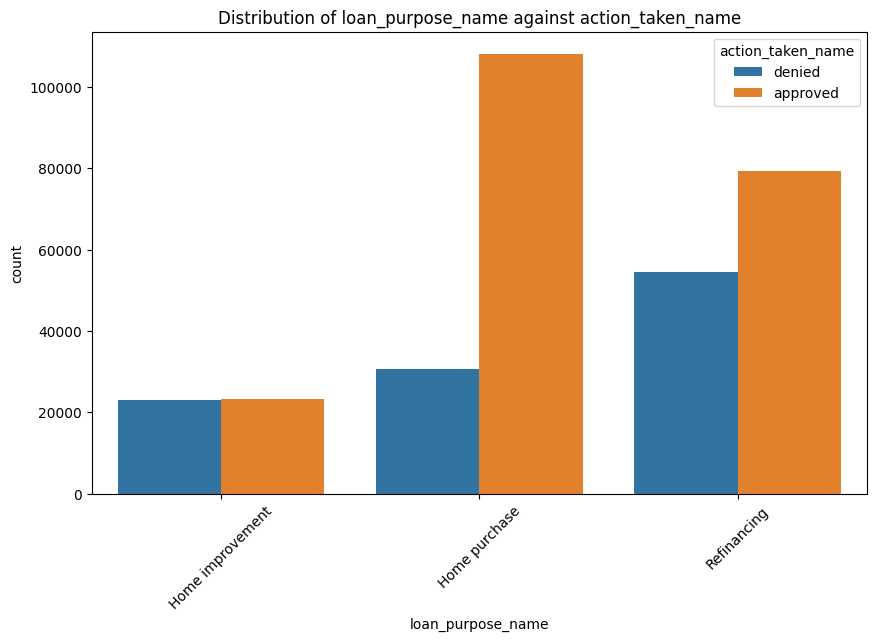

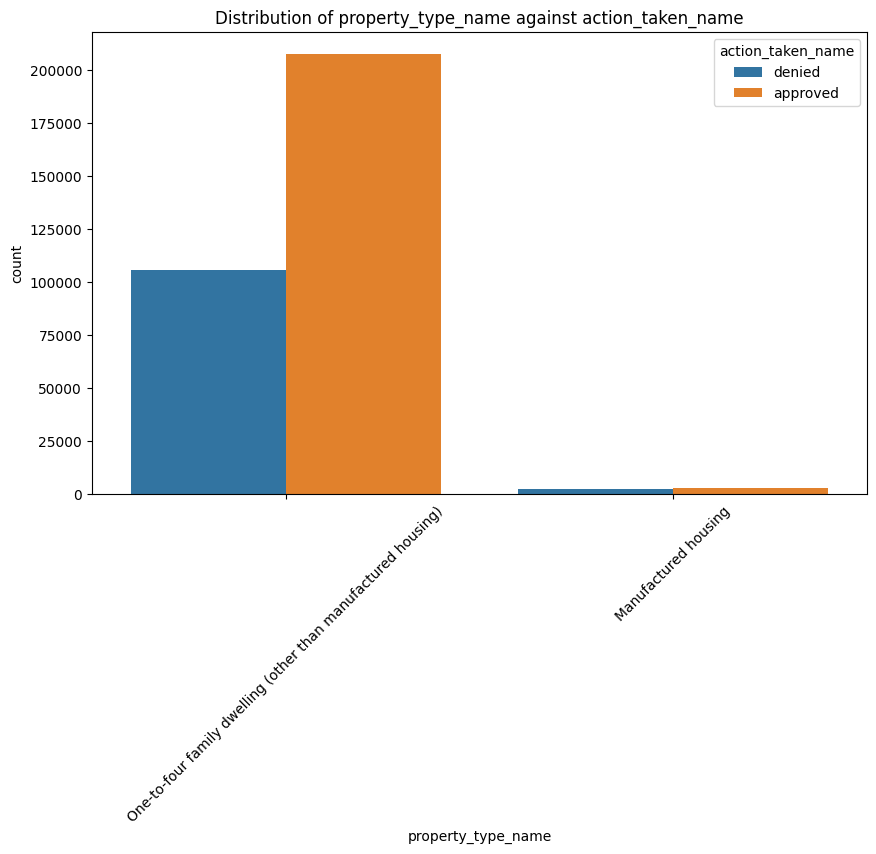

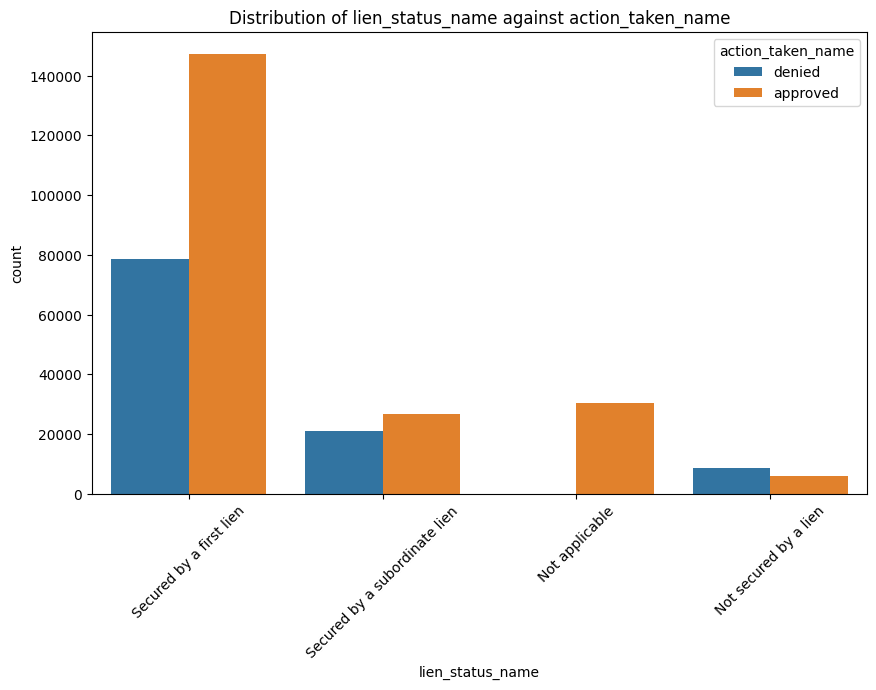

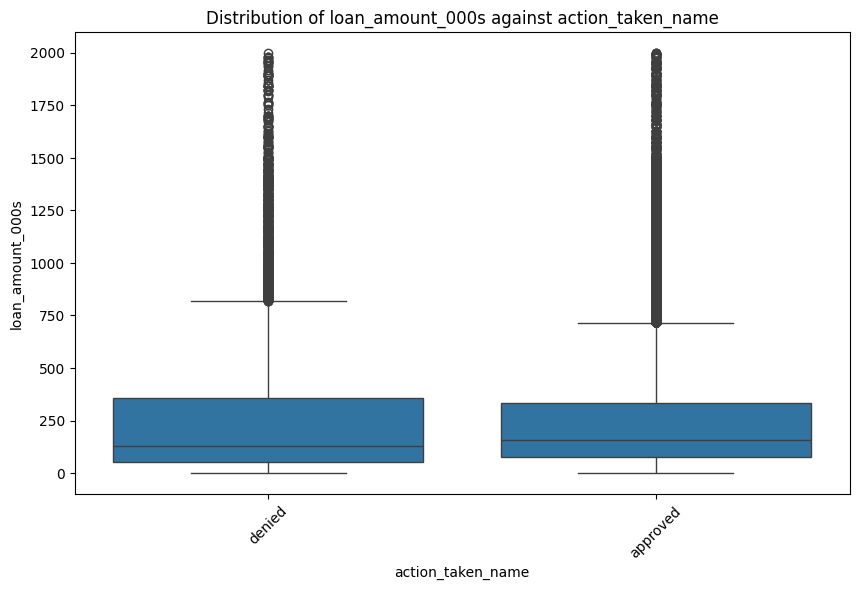

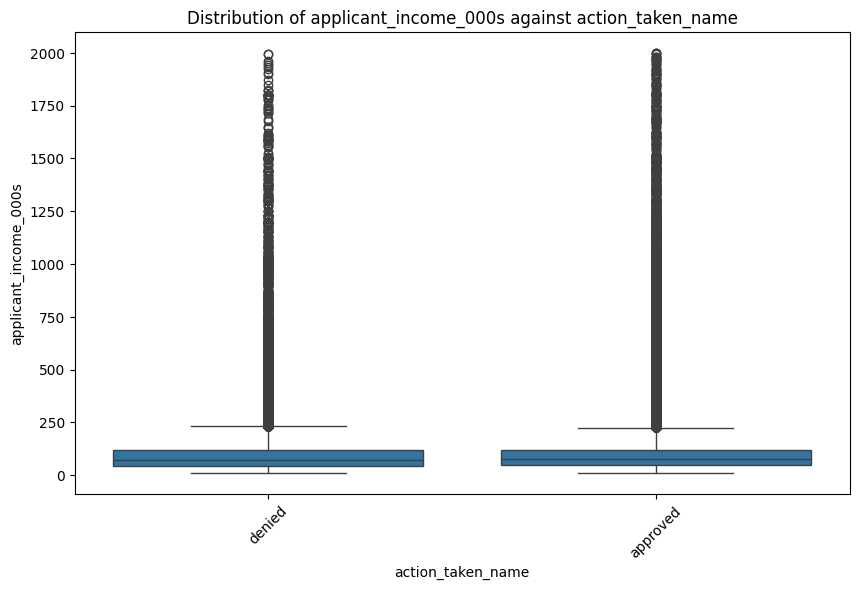

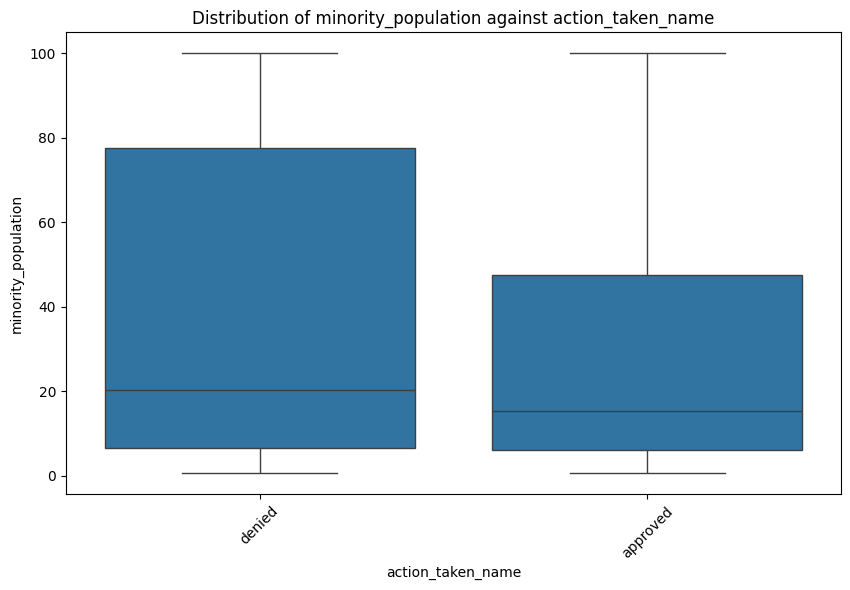

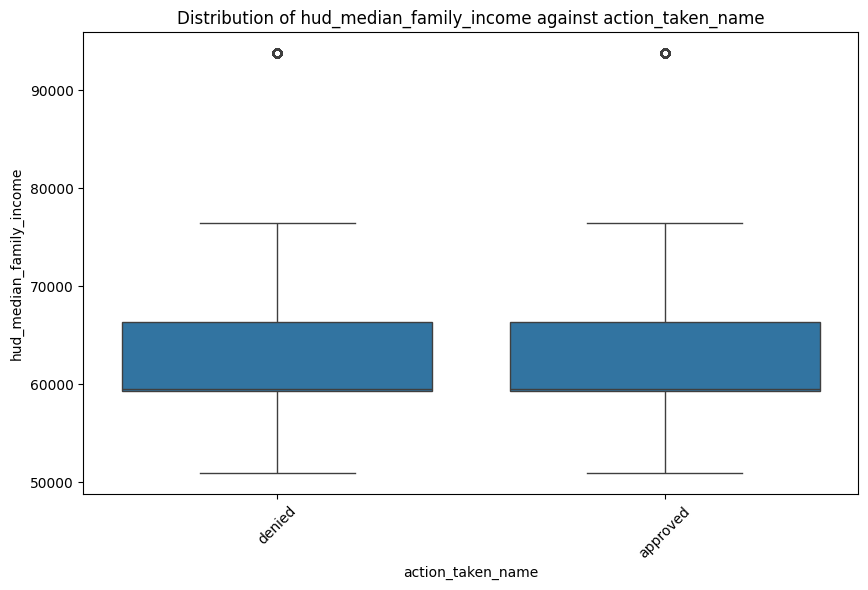

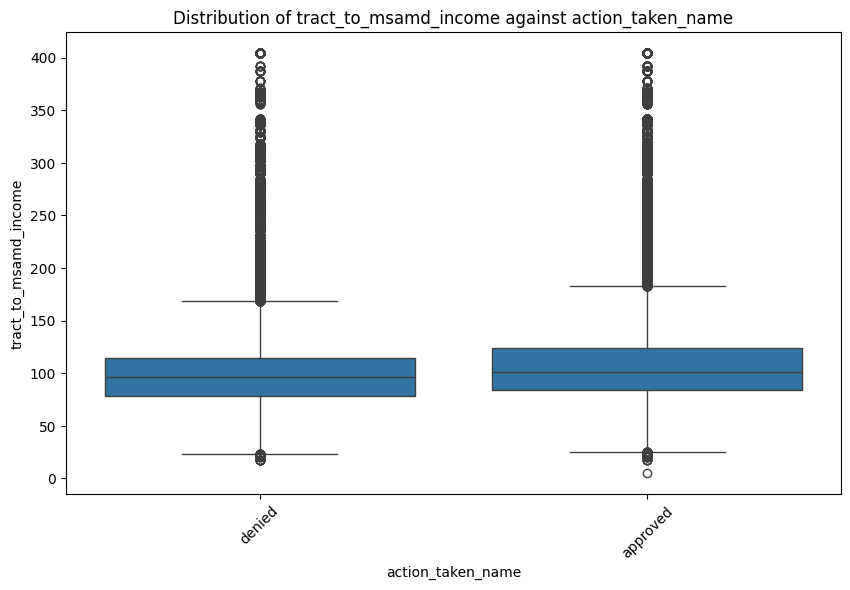

In [ ]:
categorical_columns = ['loan_type_name', 'loan_purpose_name', 'property_type_name', 'lien_status_name']
numerical_columns = ['loan_amount_000s', 'applicant_income_000s', 'minority_population',
                     'hud_median_family_income', 'tract_to_msamd_income']
target_column = 'action_taken_name'

# Plotting categorical columns
for col in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col, hue=target_column)

    plt.title(f'Distribution of {col} against {target_column}')
    plt.xticks(rotation=45)

    plt.show()

# Plotting numerical columns
for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=target_column, y=col)

    plt.title(f'Distribution of {col} against {target_column}')
    plt.xticks(rotation=45)
    plt.show()

#https://seaborn.pydata.org/generated/seaborn.countplot.html
#https://seaborn.pydata.org/generated/seaborn.boxplot.html

In [ ]:
# Percentile bounds for applicant_income_000s
income_lower_bound = np.percentile(df['applicant_income_000s'], 1)
income_upper_bound = np.percentile(df['applicant_income_000s'], 99)

# Percentile bounds for loan_amount_000s
loan_lower_bound = np.percentile(df['loan_amount_000s'], 1)
loan_upper_bound = np.percentile(df['loan_amount_000s'], 99)

# Percentile bounds for hud_median_family_income
hud_income_lower_bound = np.percentile(df['hud_median_family_income'], 1)
hud_income_upper_bound = np.percentile(df['hud_median_family_income'], 99)

# Apply filtering to all three
df = df[
    (df['applicant_income_000s'] >= income_lower_bound) &
    (df['applicant_income_000s'] <= income_upper_bound) &
    (df['loan_amount_000s'] >= loan_lower_bound) &
    (df['loan_amount_000s'] <= loan_upper_bound) &
    (df['hud_median_family_income'] >= hud_income_lower_bound) &
    (df['hud_median_family_income'] <= hud_income_upper_bound)
]

# Step 5: Feature engineering

## A) Feature creation

In [ ]:
# Creation of loan_to_income_ratio column:
df['loan_to_income_ratio'] = (df['loan_amount_000s'] / df['applicant_income_000s']).round(2)

# Checking
print(df['loan_to_income_ratio'].head())

# Note: Figures below represent the times of their annual income.
# E.g. 3.10, means that the loan amount is 3.10 times their annual income.

0    3.38
2    0.85
5    3.07
6    1.76
7    1.33
Name: loan_to_income_ratio, dtype: float64


## B) Feature selection

In [ ]:
df = df[[
    "loan_type_name",
    "property_type_name",
    "loan_purpose_name",
    "loan_amount_000s",
    "action_taken_name",
    "msamd_name",
    "census_tract_number",
    "hoepa_status_name",
    "applicant_income_000s",
    "denial_reason_name_1",
    "rate_spread",
    "lien_status_name",
    "hud_median_family_income",
    "tract_to_msamd_income",
    "minority_population",
    "number_of_owner_occupied_units",
    "ethnicity_race_sex",
    'loan_to_income_ratio'
]]

In [ ]:
df['income_sqrt'] = np.sqrt(df['applicant_income_000s'])
df['loan_amount_sqrt'] = np.sqrt(df['loan_amount_000s'])

# https://q-shick.github.io/portfolio/proj_hmda.html

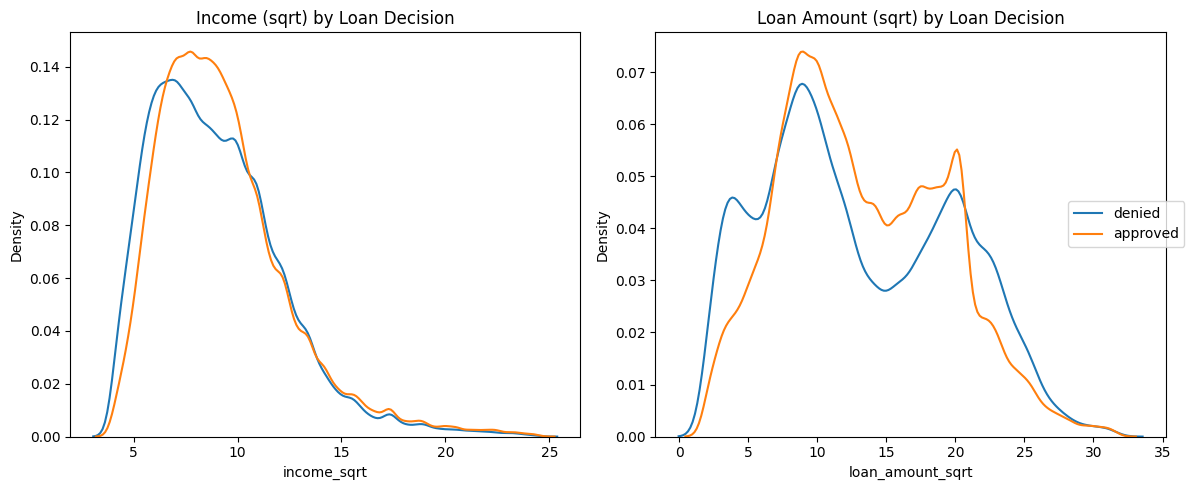

In [ ]:


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for action in df['action_taken_name'].unique():
    sns.kdeplot(
        data=df[df['action_taken_name'] == action],
        x='income_sqrt',
        ax=axes[0],
        label=action
    )
    sns.kdeplot(
        data=df[df['action_taken_name'] == action],
        x='loan_amount_sqrt',
        ax=axes[1],
        label=action
    )

axes[0].set_title("Income (sqrt) by Loan Decision")
axes[1].set_title("Loan Amount (sqrt) by Loan Decision")
axes[1].legend(bbox_to_anchor=(1.05, 0.6))
plt.tight_layout()
plt.show()


# https://q-shick.github.io/portfolio/proj_hmda.html

In [ ]:
dist_0 = df[df['action_taken_name']=='approved']['income_sqrt']
dist_1 = df[df['action_taken_name']=='denied']['income_sqrt']

stat, p_value = stats.ttest_ind(dist_0, dist_1, equal_var=False)
print("Stat/P-value: (", round(stat, 2), ',', p_value, ")")

Stat/P-value: ( 25.6 , 2.3018618003693452e-144 )


In [ ]:
from scipy import stats

# Split the data
dist_0 = df[df['action_taken_name'] == 'approved']['income_sqrt']
dist_1 = df[df['action_taken_name'] == 'denied']['income_sqrt']

# Run Welch’s t-test (assumes unequal variances)
stat, p_value = stats.ttest_ind(dist_0, dist_1, equal_var=False)

# Print results
print(f"Stat: {stat:.2f}, P-value: {p_value:.4f}")


Stat: 25.60, P-value: 0.0000


## C) Feature transformation